In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [ ]:
train_dir = "/content/MyDrive/MyDrive/M.Sc Data Science/Sem 4/CV/archive-2/train"
test_dir  = "/content/MyDrive/MyDrive/M.Sc Data Science/Sem 4/CV/archive-2/test"

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7  # Adjust according to your dataset (e.g., 7 emotions)
EPOCHS = 20
LEARNING_RATE = 1e-3
PATIENCE = 5  # For EarlyStopping

# === I. Data Preprocessing & Loading ===

# Define transforms with normalization according to ImageNet stats (for EfficientNet / ResNet)
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # mean for ImageNet
                             [0.229, 0.224, 0.225])  # std for ImageNet
    ]),
    "val": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Custom Dataset class for loading image files & labels if labels are in folder structure or CSV
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform

        # Assuming the folder structure: root_dir/class_x/xxx.png
        # Filter out non-directory entries like .DS_Store
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Collect all image paths and labels
        self.images = []
        self.labels = []
        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            # Filter out non-file entries within class folders
            for img_name in os.listdir(cls_folder):
                 img_path = os.path.join(cls_folder, img_name)
                 if os.path.isfile(img_path): # Check if it's a file
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load full training data, then split into train and val
full_dataset = EmotionDataset(train_dir, transform=data_transforms['train'])

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Update validation dataset transforms (no augmentation)
# This part of the code is problematic when using random_split
# random_split returns Subset objects, not the original dataset instance.
# Modifying the transform on val_dataset.dataset will affect the original
# full_dataset, which train_dataset is also a subset of.
# A better approach is to apply the transforms directly within __getitem__
# based on whether it's the training or validation split, or create separate
# dataset instances for train and validation after the split.
# For now, let's comment this line out to avoid unintended side effects.
# val_dataset.dataset.transform = data_transforms['val']


# Test dataset
test_dataset = EmotionDataset(test_dir, transform=data_transforms['test'])

# Data loaders
# It is better to get the actual dataset object from the Subset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Using device: cuda
Train size: 23959, Val size: 5990, Test size: 8218


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# === II. Model Definition with Transfer Learning ===

def create_model(base_model_name='efficientnet_b0', num_classes=NUM_CLASSES, pretrained=True):
    if base_model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        # Freeze base layers initially
        for param in model.parameters():
            param.requires_grad = False
        # Replace classifier head
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
    elif base_model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        for param in model.parameters():
            param.requires_grad = False
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
    else:
        raise ValueError("Unsupported model name")
    return model.to(device)

model = create_model('efficientnet_b0', NUM_CLASSES)

# === III. Training Utilities ===

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.best_state = model.state_dict()
            self.counter = 0
            if self.verbose:
                print(f"Validation accuracy improved: {score:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 149MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
# === IV. Training Loop ===

def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels)

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_acc)

        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Load best model
    model.load_state_dict(early_stopping.best_state)
    return model

In [ ]:
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/20 - Training: 100%|██████████| 731/731 [13:46<00:00,  1.13s/it]


Epoch 1: Train Loss: 1.6065, Train Acc: 0.3708, Val Loss: 1.5066, Val Acc: 0.4134
Validation accuracy improved: 0.4134


Epoch 2/20 - Training: 100%|██████████| 731/731 [01:47<00:00,  6.83it/s]


Epoch 2: Train Loss: 1.5225, Train Acc: 0.4084, Val Loss: 1.4566, Val Acc: 0.4365
Validation accuracy improved: 0.4365


Epoch 3/20 - Training: 100%|██████████| 731/731 [01:46<00:00,  6.86it/s]


Epoch 3: Train Loss: 1.4890, Train Acc: 0.4196, Val Loss: 1.4335, Val Acc: 0.4435
Validation accuracy improved: 0.4435


Epoch 4/20 - Training: 100%|██████████| 731/731 [01:45<00:00,  6.92it/s]


Epoch 4: Train Loss: 1.4723, Train Acc: 0.4279, Val Loss: 1.4253, Val Acc: 0.4581
Validation accuracy improved: 0.4581


Epoch 5/20 - Training: 100%|██████████| 731/731 [01:45<00:00,  6.96it/s]


Epoch 5: Train Loss: 1.4610, Train Acc: 0.4331, Val Loss: 1.4137, Val Acc: 0.4598
Validation accuracy improved: 0.4598


Epoch 6/20 - Training: 100%|██████████| 731/731 [01:45<00:00,  6.94it/s]


Epoch 6: Train Loss: 1.4441, Train Acc: 0.4396, Val Loss: 1.4098, Val Acc: 0.4564
EarlyStopping counter: 1/5


Epoch 7/20 - Training: 100%|██████████| 731/731 [01:44<00:00,  6.98it/s]


Epoch 7: Train Loss: 1.4379, Train Acc: 0.4453, Val Loss: 1.3937, Val Acc: 0.4704
Validation accuracy improved: 0.4704


Epoch 8/20 - Training: 100%|██████████| 731/731 [01:51<00:00,  6.56it/s]


Epoch 8: Train Loss: 1.4200, Train Acc: 0.4544, Val Loss: 1.3974, Val Acc: 0.4646
EarlyStopping counter: 1/5


Epoch 9/20 - Training: 100%|██████████| 731/731 [01:47<00:00,  6.82it/s]


Epoch 9: Train Loss: 1.4150, Train Acc: 0.4546, Val Loss: 1.3871, Val Acc: 0.4678
EarlyStopping counter: 2/5


Epoch 10/20 - Training: 100%|██████████| 731/731 [01:45<00:00,  6.91it/s]


Epoch 10: Train Loss: 1.4044, Train Acc: 0.4621, Val Loss: 1.3943, Val Acc: 0.4685
EarlyStopping counter: 3/5


Epoch 11/20 - Training: 100%|██████████| 731/731 [01:47<00:00,  6.79it/s]


Epoch 11: Train Loss: 1.3842, Train Acc: 0.4671, Val Loss: 1.3648, Val Acc: 0.4817
Validation accuracy improved: 0.4817


Epoch 12/20 - Training: 100%|██████████| 731/731 [01:46<00:00,  6.84it/s]


Epoch 12: Train Loss: 1.3739, Train Acc: 0.4740, Val Loss: 1.3676, Val Acc: 0.4791
EarlyStopping counter: 1/5


Epoch 13/20 - Training: 100%|██████████| 731/731 [01:46<00:00,  6.86it/s]


Epoch 13: Train Loss: 1.3717, Train Acc: 0.4734, Val Loss: 1.3661, Val Acc: 0.4750
EarlyStopping counter: 2/5


Epoch 14/20 - Training: 100%|██████████| 731/731 [01:49<00:00,  6.70it/s]


Epoch 14: Train Loss: 1.3661, Train Acc: 0.4781, Val Loss: 1.3543, Val Acc: 0.4863
Validation accuracy improved: 0.4863


Epoch 15/20 - Training: 100%|██████████| 731/731 [01:46<00:00,  6.84it/s]


Epoch 15: Train Loss: 1.3575, Train Acc: 0.4776, Val Loss: 1.3613, Val Acc: 0.4851
EarlyStopping counter: 1/5


Epoch 16/20 - Training: 100%|██████████| 731/731 [01:47<00:00,  6.77it/s]


Epoch 16: Train Loss: 1.3512, Train Acc: 0.4812, Val Loss: 1.3629, Val Acc: 0.4781
EarlyStopping counter: 2/5


Epoch 17/20 - Training: 100%|██████████| 731/731 [01:46<00:00,  6.88it/s]


Epoch 17: Train Loss: 1.3528, Train Acc: 0.4840, Val Loss: 1.3595, Val Acc: 0.4841
EarlyStopping counter: 3/5


Epoch 18/20 - Training: 100%|██████████| 731/731 [01:51<00:00,  6.54it/s]


Epoch 18: Train Loss: 1.3362, Train Acc: 0.4921, Val Loss: 1.3486, Val Acc: 0.4942
Validation accuracy improved: 0.4942


Epoch 19/20 - Training: 100%|██████████| 731/731 [01:51<00:00,  6.55it/s]


Epoch 19: Train Loss: 1.3294, Train Acc: 0.4958, Val Loss: 1.3467, Val Acc: 0.4916
EarlyStopping counter: 1/5


Epoch 20/20 - Training: 100%|██████████| 731/731 [01:47<00:00,  6.78it/s]


Epoch 20: Train Loss: 1.3294, Train Acc: 0.4921, Val Loss: 1.3406, Val Acc: 0.4925
EarlyStopping counter: 2/5


In [ ]:
# Define the path where you want to save the model
model_path = "/content/MyDrive/MyDrive/M.Sc Data Science/Sem 4/CV/trained_model.pth"

# Save the model's state dict
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/MyDrive/MyDrive/trained_model.pth


In [ ]:
model = create_model('efficientnet_b0', NUM_CLASSES, pretrained=True)
# Load the saved weights
model.load_state_dict(torch.load("/content/MyDrive/MyDrive/M.Sc Data Science/Sem 4/CV/trained_model.pth"))
#moving to gpu
model = model.to(device)

In [ ]:

# === VI. Fine-tuning (Optional, day 19-20) ===

def fine_tune(model, base_model_name='efficientnet_b0', learning_rate=1e-5, epochs=25):
    # Unfreeze last layers for fine tuning
    if base_model_name == 'efficientnet_b0':
        for param in model.parameters():
            param.requires_grad = True  # Unfreeze all
    elif base_model_name == 'resnet50':
        for param in model.parameters():
            param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    model = train_model(model, criterion, optimizer, scheduler, num_epochs=epochs)
    return model

# Example:
# model = fine_tune(model, 'efficientnet_b0')

In [ ]:
# Example if using EfficientNet-B0:
fine_tuned_model = fine_tune(model, base_model_name='efficientnet_b0', learning_rate=1e-5, epochs=25)

Epoch 1/25 - Training: 100%|██████████| 749/749 [08:52<00:00,  1.41it/s]


Epoch 1: Train Loss: 1.3094, Train Acc: 0.5009, Val Loss: 1.0790, Val Acc: 0.6017
Validation accuracy improved: 0.6017


Epoch 2/25 - Training: 100%|██████████| 749/749 [02:15<00:00,  5.51it/s]


Epoch 2: Train Loss: 1.2354, Train Acc: 0.5340, Val Loss: 1.0406, Val Acc: 0.6149
Validation accuracy improved: 0.6149


Epoch 3/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.56it/s]


Epoch 3: Train Loss: 1.1797, Train Acc: 0.5516, Val Loss: 1.0184, Val Acc: 0.6317
Validation accuracy improved: 0.6317


Epoch 4/25 - Training: 100%|██████████| 749/749 [02:17<00:00,  5.46it/s]


Epoch 4: Train Loss: 1.1392, Train Acc: 0.5699, Val Loss: 1.0022, Val Acc: 0.6359
Validation accuracy improved: 0.6359


Epoch 5/25 - Training: 100%|██████████| 749/749 [02:15<00:00,  5.52it/s]


Epoch 5: Train Loss: 1.1110, Train Acc: 0.5850, Val Loss: 0.9891, Val Acc: 0.6412
Validation accuracy improved: 0.6412


Epoch 6/25 - Training: 100%|██████████| 749/749 [02:15<00:00,  5.52it/s]


Epoch 6: Train Loss: 1.0822, Train Acc: 0.5965, Val Loss: 0.9770, Val Acc: 0.6444
Validation accuracy improved: 0.6444


Epoch 7/25 - Training: 100%|██████████| 749/749 [02:16<00:00,  5.51it/s]


Epoch 7: Train Loss: 1.0434, Train Acc: 0.6072, Val Loss: 0.9647, Val Acc: 0.6513
Validation accuracy improved: 0.6513


Epoch 8/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.57it/s]


Epoch 8: Train Loss: 1.0165, Train Acc: 0.6186, Val Loss: 0.9483, Val Acc: 0.6586
Validation accuracy improved: 0.6586


Epoch 9/25 - Training: 100%|██████████| 749/749 [02:15<00:00,  5.52it/s]


Epoch 9: Train Loss: 0.9954, Train Acc: 0.6271, Val Loss: 0.9402, Val Acc: 0.6574
EarlyStopping counter: 1/5


Epoch 10/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.58it/s]


Epoch 10: Train Loss: 0.9705, Train Acc: 0.6369, Val Loss: 0.9339, Val Acc: 0.6594
Validation accuracy improved: 0.6594


Epoch 11/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.59it/s]


Epoch 11: Train Loss: 0.9528, Train Acc: 0.6426, Val Loss: 0.9301, Val Acc: 0.6578
EarlyStopping counter: 1/5


Epoch 12/25 - Training: 100%|██████████| 749/749 [02:16<00:00,  5.50it/s]


Epoch 12: Train Loss: 0.9235, Train Acc: 0.6555, Val Loss: 0.9228, Val Acc: 0.6683
Validation accuracy improved: 0.6683


Epoch 13/25 - Training: 100%|██████████| 749/749 [02:16<00:00,  5.47it/s]


Epoch 13: Train Loss: 0.9161, Train Acc: 0.6593, Val Loss: 0.9230, Val Acc: 0.6621
EarlyStopping counter: 1/5


Epoch 14/25 - Training: 100%|██████████| 749/749 [02:17<00:00,  5.46it/s]


Epoch 14: Train Loss: 0.8919, Train Acc: 0.6677, Val Loss: 0.9126, Val Acc: 0.6678
EarlyStopping counter: 2/5


Epoch 15/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.56it/s]


Epoch 15: Train Loss: 0.8740, Train Acc: 0.6747, Val Loss: 0.9019, Val Acc: 0.6726
Validation accuracy improved: 0.6726


Epoch 16/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.58it/s]


Epoch 16: Train Loss: 0.8492, Train Acc: 0.6842, Val Loss: 0.8989, Val Acc: 0.6756
Validation accuracy improved: 0.6756


Epoch 17/25 - Training: 100%|██████████| 749/749 [02:17<00:00,  5.46it/s]


Epoch 17: Train Loss: 0.8298, Train Acc: 0.6925, Val Loss: 0.8971, Val Acc: 0.6750
EarlyStopping counter: 1/5


Epoch 18/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.56it/s]


Epoch 18: Train Loss: 0.8193, Train Acc: 0.6951, Val Loss: 0.8934, Val Acc: 0.6811
Validation accuracy improved: 0.6811


Epoch 19/25 - Training: 100%|██████████| 749/749 [02:12<00:00,  5.63it/s]


Epoch 19: Train Loss: 0.8015, Train Acc: 0.7030, Val Loss: 0.8944, Val Acc: 0.6793
EarlyStopping counter: 1/5


Epoch 20/25 - Training: 100%|██████████| 749/749 [02:15<00:00,  5.53it/s]


Epoch 20: Train Loss: 0.7810, Train Acc: 0.7086, Val Loss: 0.8998, Val Acc: 0.6773
EarlyStopping counter: 2/5


Epoch 21/25 - Training: 100%|██████████| 749/749 [02:16<00:00,  5.49it/s]


Epoch 21: Train Loss: 0.7678, Train Acc: 0.7137, Val Loss: 0.8973, Val Acc: 0.6823
Validation accuracy improved: 0.6823


Epoch 22/25 - Training: 100%|██████████| 749/749 [02:16<00:00,  5.51it/s]


Epoch 22: Train Loss: 0.7550, Train Acc: 0.7185, Val Loss: 0.8946, Val Acc: 0.6806
EarlyStopping counter: 1/5


Epoch 23/25 - Training: 100%|██████████| 749/749 [02:15<00:00,  5.52it/s]


Epoch 23: Train Loss: 0.7387, Train Acc: 0.7234, Val Loss: 0.8883, Val Acc: 0.6823
EarlyStopping counter: 2/5


Epoch 24/25 - Training: 100%|██████████| 749/749 [02:16<00:00,  5.47it/s]


Epoch 24: Train Loss: 0.7198, Train Acc: 0.7305, Val Loss: 0.8896, Val Acc: 0.6818
EarlyStopping counter: 3/5


Epoch 25/25 - Training: 100%|██████████| 749/749 [02:14<00:00,  5.57it/s]


Epoch 25: Train Loss: 0.7067, Train Acc: 0.7351, Val Loss: 0.8988, Val Acc: 0.6868
Validation accuracy improved: 0.6868


In [ ]:
torch.save(fine_tuned_model.state_dict(), "/content/MyDrive/MyDrive/M.Sc Data Science/Sem 4/CV/eff_fine_tuned_model.pth")

In [ ]:
# === V. Evaluation on Test Set ===

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

evaluate_model(model, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0     0.5035    0.5292    0.5160       958
           1     0.7667    0.4144    0.5380       111
           2     0.5438    0.3370    0.4161      1454
           3     0.7956    0.8687    0.8305      1774
           4     0.4840    0.6853    0.5673      1233
           5     0.5919    0.5272    0.5577      1857
           6     0.7065    0.7762    0.7397       831

    accuracy                         0.6149      8218
   macro avg     0.6274    0.5911    0.5950      8218
weighted avg     0.6148    0.6149    0.6063      8218

Confusion Matrix:
[[ 507    5   83   68  140  121   34]
 [  31   46    4    7    9   12    2]
 [ 197    2  490   83  208  315  159]
 [  32    2   25 1541  104   36   34]
 [  60    0   47   91  845  172   18]
 [ 158    5  186  103  405  979   21]
 [  22    0   66   44   35   19  645]]


In [ ]:

# === V. Evaluation on Test Set ===

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

evaluate_model(fine_tuned_model, test_loader)

In [ ]:
evaluate_model(fine_tuned_model, test_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0     0.5035    0.5292    0.5160       958
           1     0.7667    0.4144    0.5380       111
           2     0.5438    0.3370    0.4161      1454
           3     0.7956    0.8687    0.8305      1774
           4     0.4840    0.6853    0.5673      1233
           5     0.5919    0.5272    0.5577      1857
           6     0.7065    0.7762    0.7397       831

    accuracy                         0.6149      8218
   macro avg     0.6274    0.5911    0.5950      8218
weighted avg     0.6148    0.6149    0.6063      8218

Confusion Matrix:
[[ 507    5   83   68  140  121   34]
 [  31   46    4    7    9   12    2]
 [ 197    2  490   83  208  315  159]
 [  32    2   25 1541  104   36   34]
 [  60    0   47   91  845  172   18]
 [ 158    5  186  103  405  979   21]
 [  22    0   66   44   35   19  645]]


In [ ]:
class_names = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    return cm


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

       Angry     0.5035    0.5292    0.5160       958
   Disgusted     0.7667    0.4144    0.5380       111
     Fearful     0.5438    0.3370    0.4161      1454
       Happy     0.7956    0.8687    0.8305      1774
     Neutral     0.4840    0.6853    0.5673      1233
         Sad     0.5919    0.5272    0.5577      1857
   Surprised     0.7065    0.7762    0.7397       831

    accuracy                         0.6149      8218
   macro avg     0.6274    0.5911    0.5950      8218
weighted avg     0.6148    0.6149    0.6063      8218

Confusion Matrix:
[[ 507    5   83   68  140  121   34]
 [  31   46    4    7    9   12    2]
 [ 197    2  490   83  208  315  159]
 [  32    2   25 1541  104   36   34]
 [  60    0   47   91  845  172   18]
 [ 158    5  186  103  405  979   21]
 [  22    0   66   44   35   19  645]]


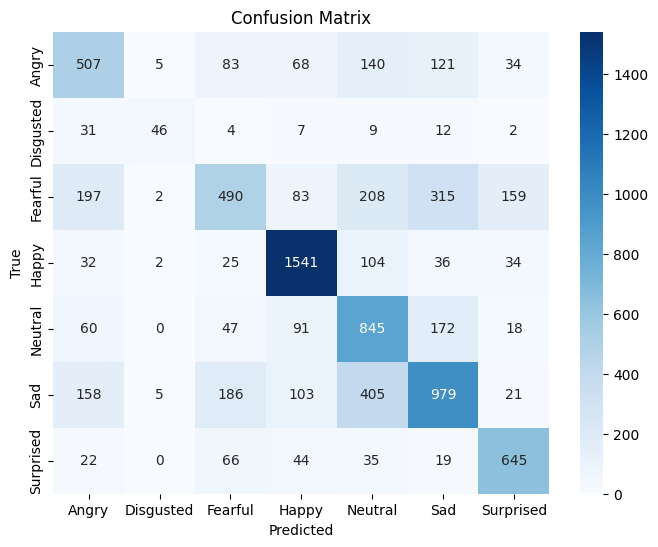

In [ ]:
cm = evaluate_model(fine_tuned_model, test_loader, class_names)

plot_confusion_matrix(cm, class_names)
